# Assignment 9

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Part 1: Data Visualization [1 pts]

1. Download the data. Load and standardize the images using min-max normalization. Use
an 80%-20% split of the data for training and testing in this assignment.

2. Use visualization to explore the images. What differences do you notice between the
images?

In [2]:
# load
xrays = np.load('/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_09/xray_images.npz')

images = xrays['images']

# images has shape of (11219, 64, 64) and is np array
# 11219 images, each image is 64x64 pixels

In [3]:
# standardize
def normalization_funct(shape):
    minShape = np.min(shape, axis=0)  # Minimum for each column
    maxShape = np.max(shape, axis=0)  # Maximum for each column
    y = (shape - minShape) / (maxShape - minShape)
    return y

In [4]:
# apply normalization funct
normalized_images = normalization_funct(images)

In [5]:
# split data
x_train, x_test = train_test_split(normalized_images, test_size=0.2, random_state=42)

In [6]:
# After your train_test_split
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

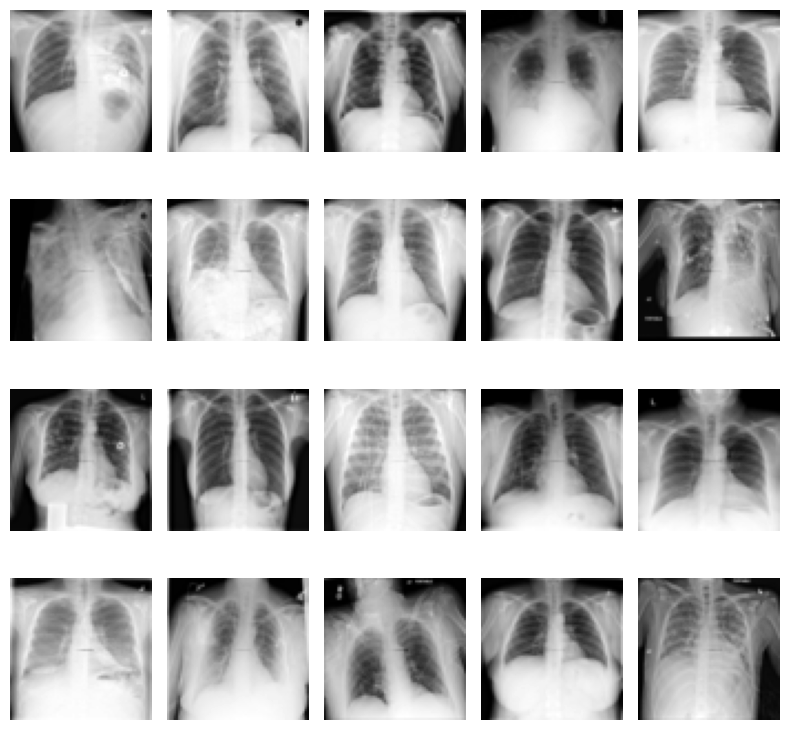

In [39]:
# plot first 9 images in 3x3 row
plt.figure(figsize=(8, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

I noticed some images have a higher opacity or whiteness than others, possibly indicating something is blocking the passage of the rays through that area in the chest. This could be fluid or pus, possibly caused by pneumonia. 

# Part 2: Generative Variational Autoencoder [2 pts]

• Train a convolutional variational autoencoder to learn a low-dimensional representation
of the data.

• Use three different latent space sizes: 4, 16, and 32 (i.e., build separate models).

• Use two a two-term loss function:

    o Reconstruction loss: Binary Cross Entropy between each pixel of the input and
    reconstructed images.
    
    o Kullback-Leibler (KL) loss: KL divergence between the latent distribution and a
    standard normal distribution.

• Train the model for at least 100 epochs (adjust as needed for optimal results).

• Report the training and testing history plots.

Hints:

● Use a symmetric encoder-decoder architecture.

● Use Conv2D with stride=2 for each encoder layer, and Conv2DTranspose with stride=2
for each decoder layer

● Do not use activation functions in the input, latent, or output layers.

In [8]:
input_shape = (64, 64, 1)

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Reconstruction loss - TWO TERM LOSS binary and kl
        recon_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(inputs, reconstruction)
        ) * input_shape[0] * input_shape[1]
        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
    
        # Add total VAE loss
        self.add_loss(recon_loss + kl_loss)
        return reconstruction

class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            epsilon = tf.random.normal(shape=tf.shape(z_mean))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
# vae struct from lec 25 
def build_vae(latent_dim):

    # Encoder
    encoder_inputs = keras.Input(shape=input_shape)
    #  Conv2D with stride=2 for each encoder layer
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    
    x = layers.Flatten()(x)
    
    # Dense
    x = layers.Dense(16, activation="relu")(x)
    
    # Latent Space
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    # Sampling
    z = Sampling()([z_mean, z_log_var])
    
    # make encoder model
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()

    
    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,), name="decoder_input")
    # Dense
    x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
    #Latent to 3d tensor
    x = layers.Reshape((16, 16, 64))(x)
    
    # Conv2DTranspose with stride=2 for each decoder layer
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    
    
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()
    
    
    # make vae
    vae = VAE(encoder, decoder)

        
    # return
    return vae


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │    262,160 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 4)         │         68 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 4)         │         68 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 4)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 281,112 (1.07 MB)

 Trainable params: 281,112 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16384)          │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,601 (537.50 KB)

 Trainable params: 137,601 (537.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 49s 340ms/step - loss: 2730.1577 - val_loss: 2527.8154
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - loss: 2499.8020 - val_loss: 2449.7832
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - loss: 2442.2124 - val_loss: 2440.1926
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 307ms/step - loss: 2436.4900 - val_loss: 2437.0085
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 287ms/step - loss: 2435.3999 - val_loss: 2433.2122
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 282ms/step - loss: 2430.8218 - val_loss: 2431.1338
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - loss: 2429.4231 - val_loss: 2430.4434
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - loss: 2431.2034 - val_loss: 2428.4312
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 2428.5271 - val_loss: 2428.3142
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 320ms/step - loss: 2424.9941 - val_loss: 2427.6082
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━

141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - loss: 2403.4358 - val_loss: 2412.6511
Epoch 64/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - loss: 2401.3801 - val_loss: 2413.7234
Epoch 65/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - loss: 2402.6589 - val_loss: 2412.8865
Epoch 66/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 316ms/step - loss: 2402.5354 - val_loss: 2411.5906
Epoch 67/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - loss: 2404.4634 - val_loss: 2410.4065
Epoch 68/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - loss: 2401.8354 - val_loss: 2412.4504
Epoch 69/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - loss: 2399.2415 - val_loss: 2412.0454
Epoch 70/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - loss: 2402.7661 - val_loss: 2412.5442
Epoch 71/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - loss: 2402.3354 - val_loss: 2410.5845
Epoch 72/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - loss: 2399.4404 - val_loss: 2410.7151
Epoch 73/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2

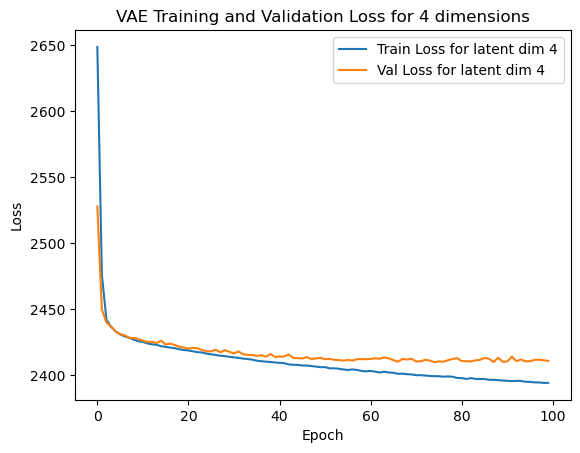

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16384)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │    262,160 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        272 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        272 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 16)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 281,520 (1.07 MB)

 Trainable params: 281,520 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16384)          │       278,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,209 (1.27 MB)

 Trainable params: 334,209 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 212ms/step - loss: 2705.5964 - val_loss: 2526.3416
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - loss: 2496.7180 - val_loss: 2449.3545
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - loss: 2446.2571 - val_loss: 2440.3596
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - loss: 2439.2874 - val_loss: 2435.9915
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - loss: 2434.3979 - val_loss: 2435.6274
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - loss: 2432.6355 - val_loss: 2430.4551
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - loss: 2427.9690 - val_loss: 2430.4121
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 268ms/step - loss: 2430.2280 - val_loss: 2427.8418
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 242ms/step - loss: 2423.2998 - val_loss: 2427.3792
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - loss: 2428.7268 - val_loss: 2425.6980
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━

141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 196ms/step - loss: 2363.0359 - val_loss: 2376.0830
Epoch 64/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - loss: 2364.7856 - val_loss: 2375.0996
Epoch 65/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - loss: 2363.5623 - val_loss: 2375.6184
Epoch 66/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 247ms/step - loss: 2365.5474 - val_loss: 2375.3992
Epoch 67/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - loss: 2368.9319 - val_loss: 2375.9209
Epoch 68/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - loss: 2367.0925 - val_loss: 2375.2546
Epoch 69/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 36s 256ms/step - loss: 2363.3352 - val_loss: 2375.4685
Epoch 70/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 235ms/step - loss: 2362.7141 - val_loss: 2375.3992
Epoch 71/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 224ms/step - loss: 2362.2134 - val_loss: 2377.5061
Epoch 72/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 244ms/step - loss: 2364.2195 - val_loss: 2376.2827
Epoch 73/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3

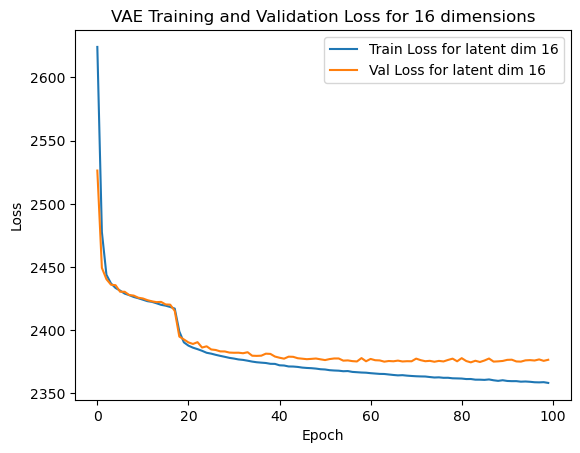

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16384)     │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │    262,160 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │        544 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │        544 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 32)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 282,064 (1.08 MB)

 Trainable params: 282,064 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16384)          │       540,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,353 (2.27 MB)

 Trainable params: 596,353 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 232ms/step - loss: 2697.6064 - val_loss: 2468.1467
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - loss: 2454.4097 - val_loss: 2438.2544
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - loss: 2437.9446 - val_loss: 2432.5964
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - loss: 2435.0571 - val_loss: 2425.1748
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 251ms/step - loss: 2413.1729 - val_loss: 2403.7344
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 242ms/step - loss: 2398.7068 - val_loss: 2397.9043
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 236ms/step - loss: 2393.3184 - val_loss: 2393.9934
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 244ms/step - loss: 2388.1206 - val_loss: 2391.9822
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - loss: 2385.5129 - val_loss: 2391.1433
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - loss: 2385.8293 - val_loss: 2389.5671
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━

141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 246ms/step - loss: 2366.6453 - val_loss: 2375.1892
Epoch 64/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - loss: 2364.6179 - val_loss: 2376.4023
Epoch 65/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - loss: 2361.1631 - val_loss: 2376.3938
Epoch 66/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - loss: 2360.8264 - val_loss: 2376.4033
Epoch 67/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - loss: 2363.3340 - val_loss: 2378.2698
Epoch 68/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - loss: 2359.8271 - val_loss: 2376.1660
Epoch 69/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - loss: 2358.7031 - val_loss: 2376.3713
Epoch 70/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - loss: 2364.0312 - val_loss: 2377.8589
Epoch 71/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - loss: 2361.4529 - val_loss: 2375.6633
Epoch 72/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - loss: 2361.8420 - val_loss: 2375.8279
Epoch 73/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2

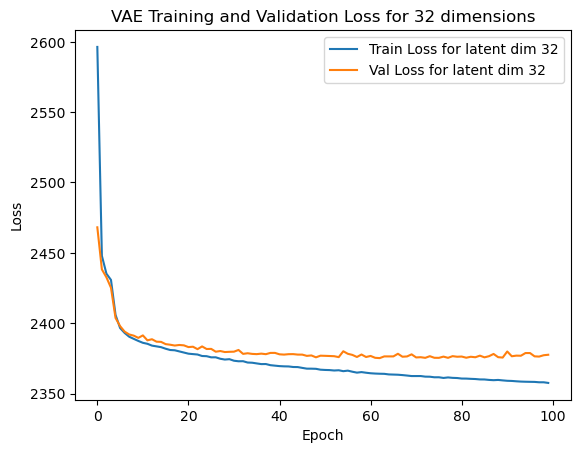

In [10]:
# latent dimensions for sep models
latent_dim = [4, 16, 32]

# to store all 3 models
all_vaes = {}

for dim in latent_dim:
    vae = build_vae(dim)
    
    # compile
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

    # 8) Train
    history = vae.fit(
        x_train,
        epochs=100,
        batch_size=64,
        validation_data=(x_test, None)
    )
    
    vae.save(f"vae_latent_{dim}.keras")
    
    # store the model in the dictionary
    all_vaes[dim] = vae

    
    # 9) Plot loss curves
    plt.figure()
    plt.plot(history.history["loss"], label=f"Train Loss for latent dim {dim}")
    plt.plot(history.history["val_loss"], label=f"Val Loss for latent dim {dim}")
    
    plt.title(f"VAE Training and Validation Loss for {dim} dimensions")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Part 3: Visualize Reconstruction and PCA/t-SNE [2 pts]

• For each model from Part 2:

    o Visualize the original image vs. reconstructed image for 10 images from the test
    dataset.
    
    o Randomly sample 1000 images from the training dataset and encode each one
    into its latent vector.
    
    o Cluster the vectors (K-means clustering) and visualize images from a few of the
    clusters.
    
    o Perform PCA and t-SNE on these latent vectors and make plots visualizing the
    distribution of the images for the first two dimensions, coloring points by cluster.

• Discuss:

    o What do you notice about the reconstruction performance between the different
    models? Why are there differences?
    
    o Do you notice differences in images between different clusters? Is the latent
    space organized differently between models?
    
    o Are the PCA or t-SNE plots different between models? Why or why not?

In [23]:
all_vaes

{4: <VAE name=vae, built=True>,
 16: <VAE name=vae_1, built=True>,
 32: <VAE name=vae_2, built=True>}

Images for latent dim 4


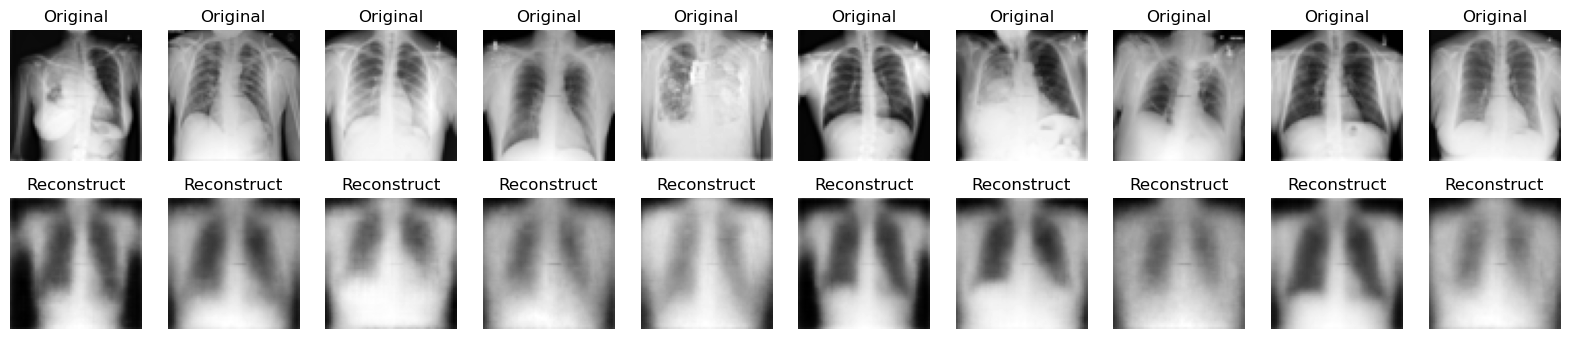

Images for latent dim 16


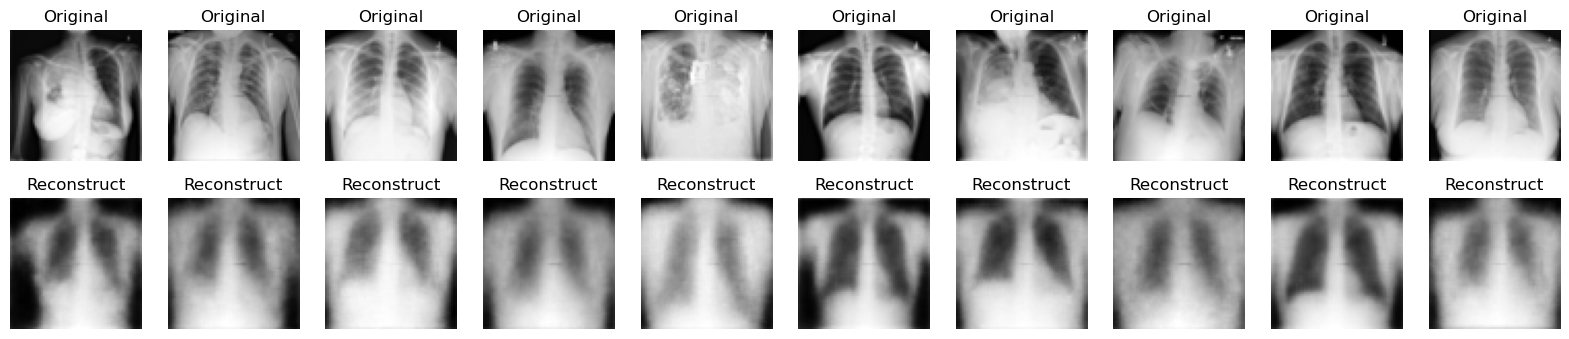

Images for latent dim 32


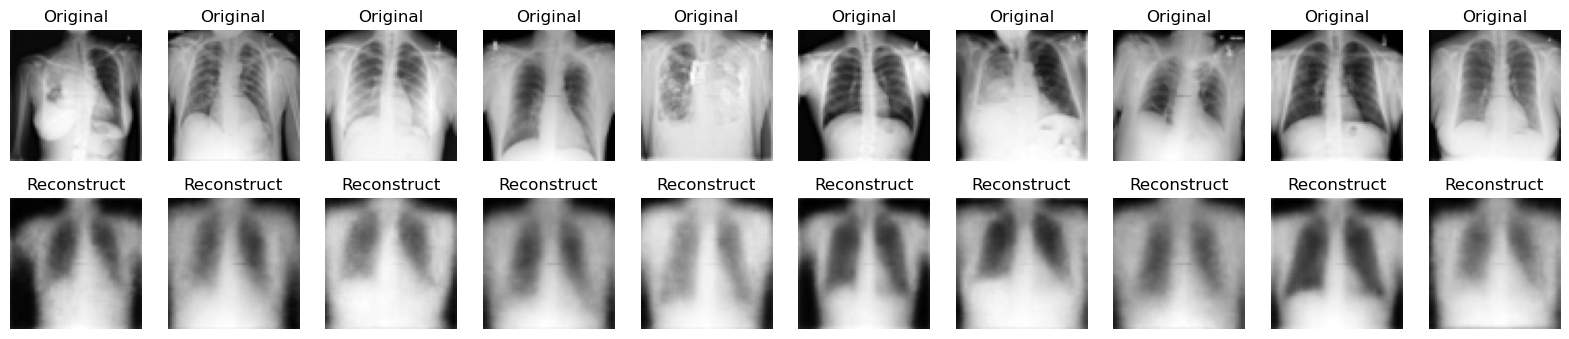

In [24]:
# visualize original image vs reconstructed image for 10 images from test dataset
def show_reconstruct(vae_model, x_test):
    # show 10
    sample = x_test[:10]
    
    # z_mean, z_log_var, z = vae_model.encoder(sample) 
    recon = vae_model(sample) 
    
    
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(2,10,i+1)
        
        img = np.squeeze(sample[i])
        
        plt.imshow(img, cmap="gray")
        plt.title("Original")
        plt.axis("off")
        
        # reconstructed image
        ax = plt.subplot(2,10,i+11)
        
        rec_img = np.squeeze(recon[i])
        plt.imshow(rec_img, cmap="gray")
        plt.title("Reconstruct")
        plt.axis("off")
    plt.show()

# Cluster the vectors (K-means clustering) and visualize images from a few of the clusters.
for dim in latent_dim:
    print(f"Images for latent dim {dim}")
    show_reconstruct(all_vaes[dim], x_test)
    

Regarding the reconstruction performance between the three models, they all gave similar reconstructions, maybe latent dimension 16 has slightly less opacity than oters images. Hypothetically there would be diferences between latent dimensions since a larger latent dimension, such as latent dim 32 can capture more complex patterns and details, but could lead to overfitting. A smaller latent dimension, such as latent dim 4, could limit the model's ability to capture the data's complexity. 

In [43]:
# Cluster the vectors (K-means clustering) and visualize images from a few of the clusters.
def cluster_n_plot(latents, x_data):
    kmeans = KMeans(n_clusters=5, random_state=42).fit(latents)
    labels = kmeans.labels_
    
    # visualize images from each cluster 
    for cluster in range(5):
        
        cluster_indices = np.where(labels==cluster)[0][:5]
        
        # plotting
        plt.figure(figsize=(10,2))
        for i, idx in enumerate(cluster_indices):
            ax = plt.subplot(1,5,i+1)
            
            plt.imshow(x_data[idx].squeeze(), cmap="gray")
            plt.title(f"Cluster {cluster}")
            plt.axis("off")
            
        plt.tight_layout()
        plt.show()
    
    return labels
        

Clustering for latent dim 4


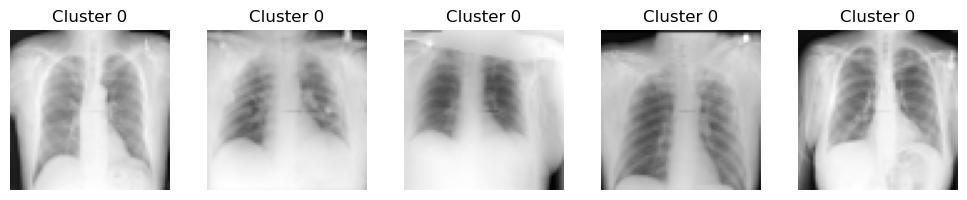

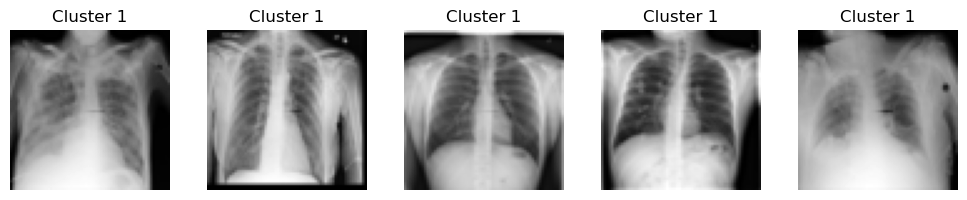

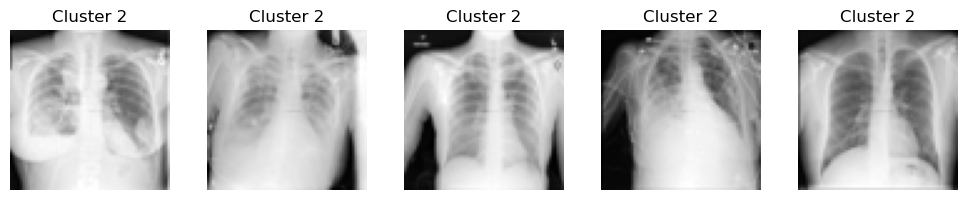

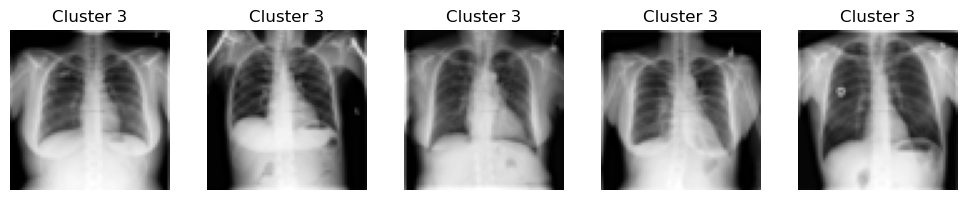

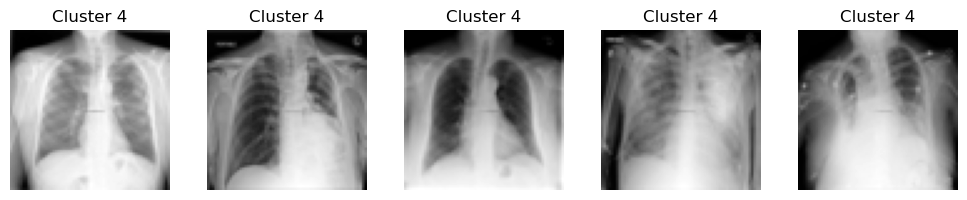

Clustering for latent dim 16


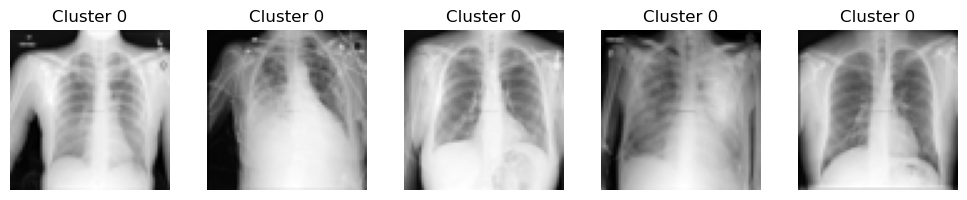

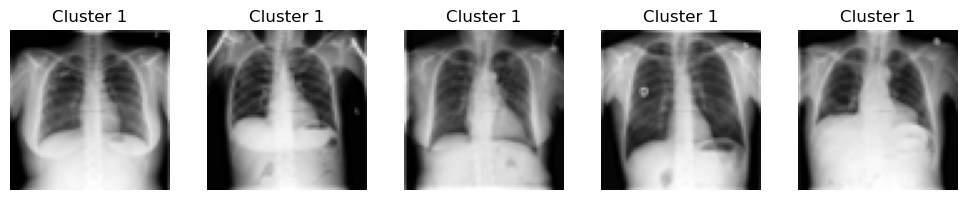

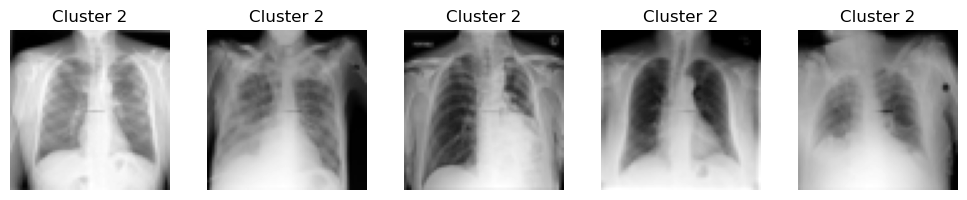

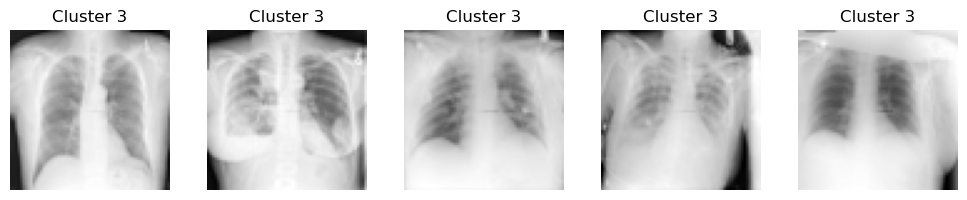

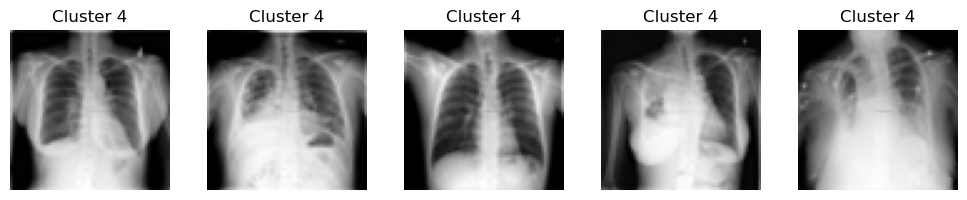

Clustering for latent dim 32


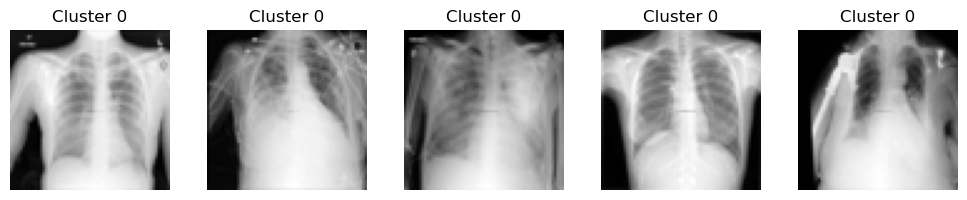

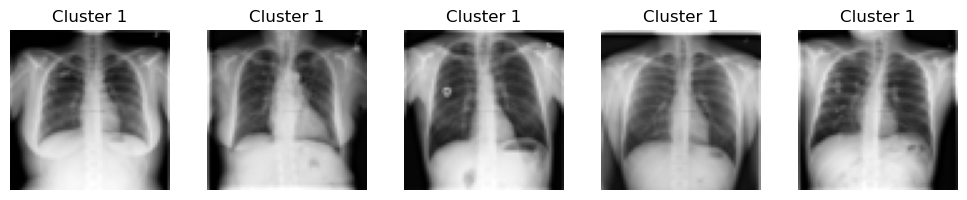

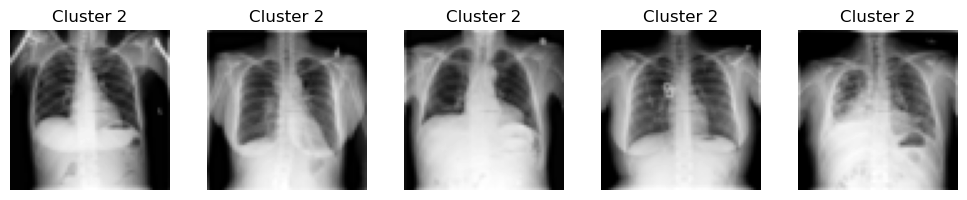

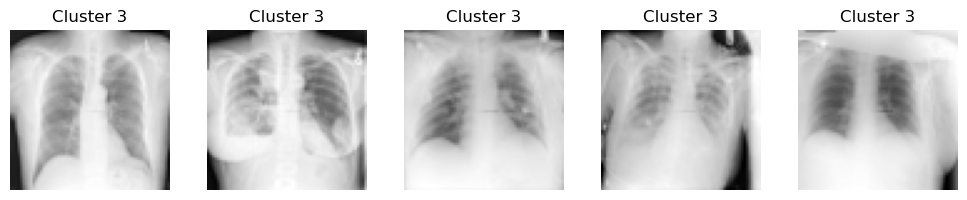

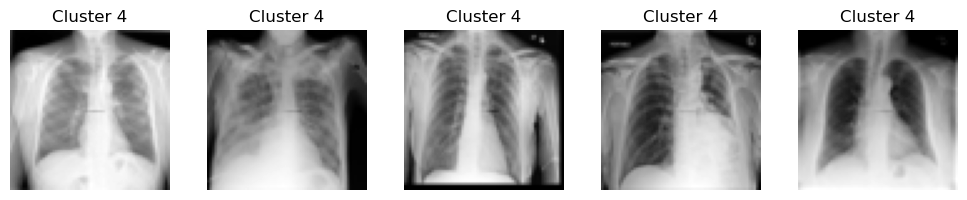

In [44]:
# Randomly sample 1000 images from the training dataset and encode each one
# into its latent vector.

# subset 1000 images
x_subset = x_test[np.random.choice(len(x_test), 1000, replace=False)]

for dim in latent_dim:
    print(f"Clustering for latent dim {dim}")
    z_mean, _, _ = all_vaes[dim].encoder(x_subset)
    cluster_n_plot(z_mean.numpy(), x_subset)

Yes, there are differences in images between different clusters. Some clusters, wuch as the second cluster for latent dimension 16 includes the most clear xrays without some type of fluid obstruction, whereas the fourth cluster (Cluster 3) is the most opaque xrays, possibly showing a more severe case of pneumonia. The other three clusters seem to be more of an in-between with the last cluster (Cluster 4) being the second most clear xray, then the third cluster, then cluster 0 being the second most opaque xray. 

The latent space seems to be organized differently between models but generally with these same five differences between clusters. 

In [27]:
# PCA and t-SNE on these latent vectors and make plots
# visualzie distribution of the images for the first two dimensions, coloring points by cluster.

def visualize_emb(latents, labels):
    pca = PCA(n_components=2).fit_transform(latents)
    tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latents)
    
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    
    # pca plot
    # 2 dimensions
    ax[0].scatter(pca[:,0], pca[:,1], c=labels)
    ax[0].set_title("PCA")
    
    # tsne plot
    # 2 dimensions
    ax[1].scatter(tsne[:,0], tsne[:,1], c=labels)
    ax[1].set_title("t-SNE")
    
    plt.show()

PCA and t-SNE plots for latent dim 4


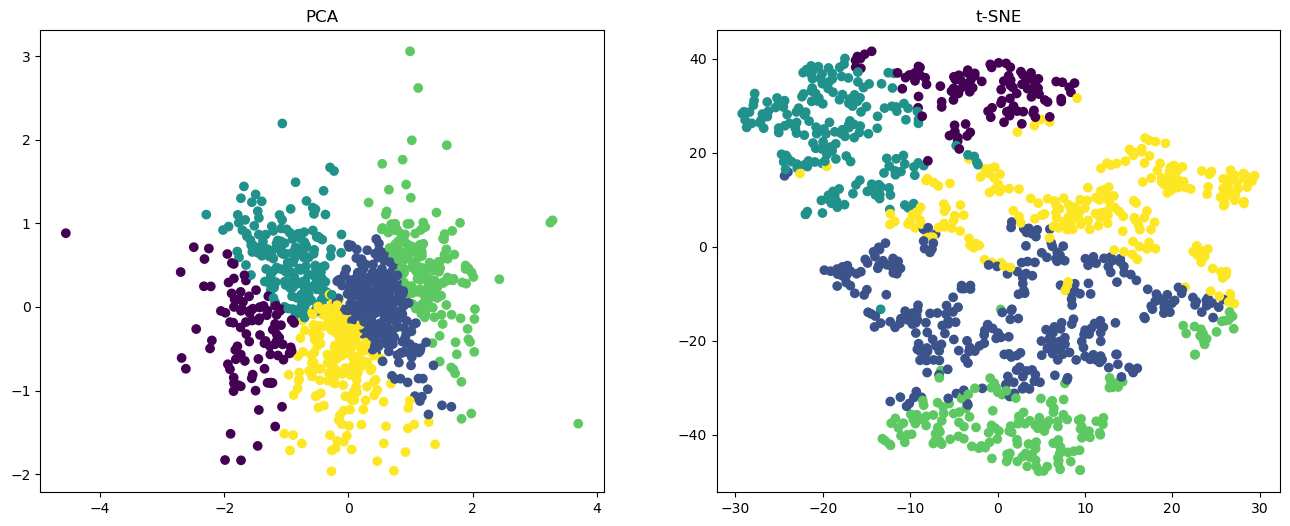

PCA and t-SNE plots for latent dim 16


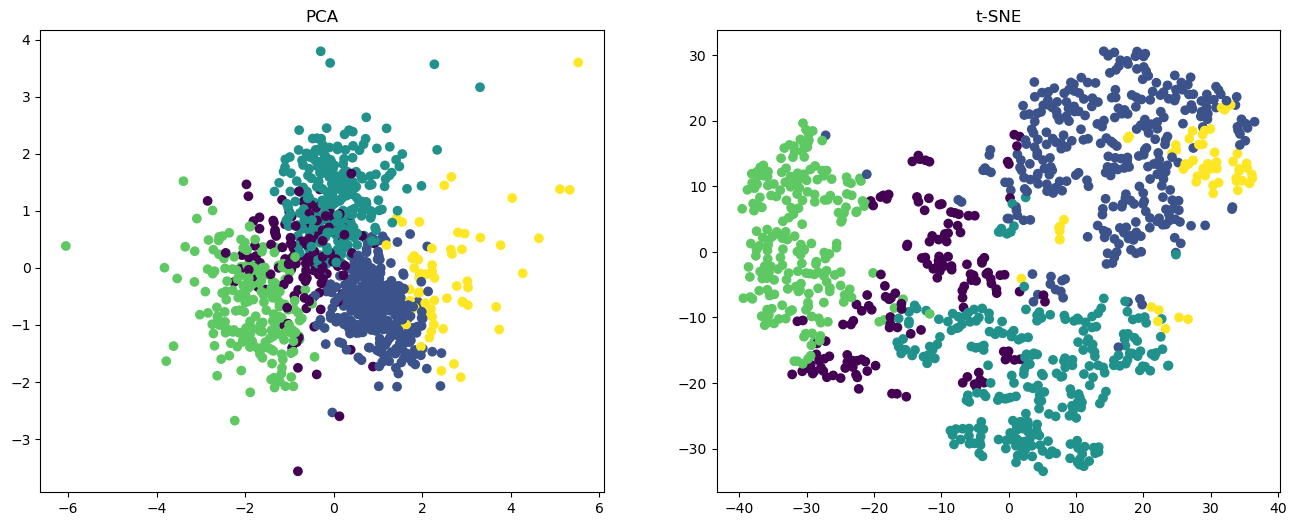

PCA and t-SNE plots for latent dim 32


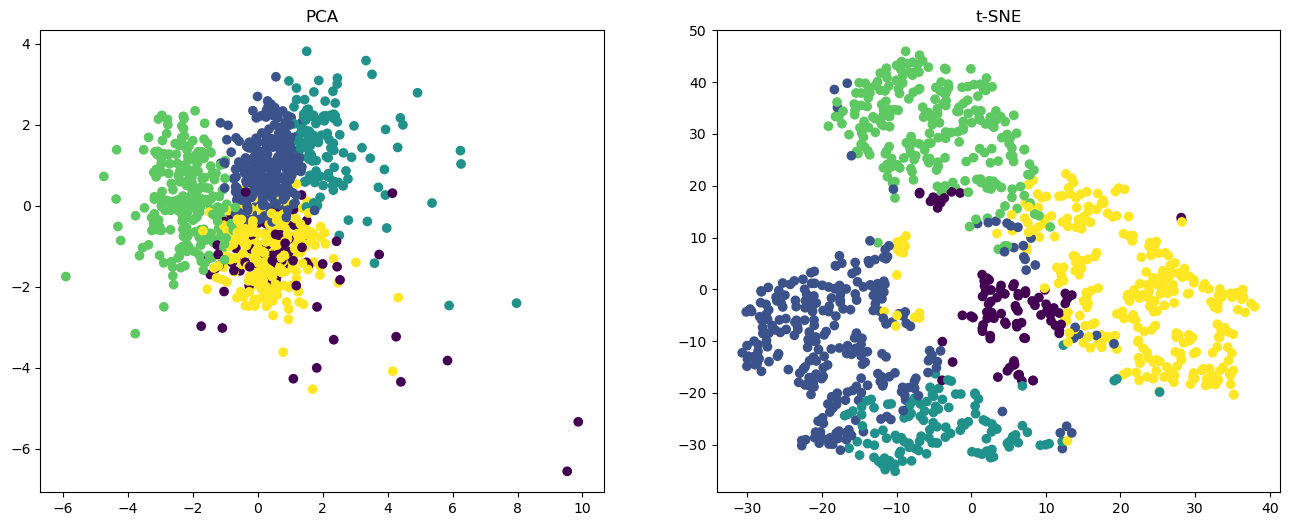

In [45]:
for dim in latent_dim:
    z_mean, _, _ = all_vaes[dim].encoder(x_subset)
    
    kmeans = KMeans(n_clusters=5, random_state=42).fit(z_mean.numpy())
    labels = kmeans.labels_
    
    print(f"PCA and t-SNE plots for latent dim {dim}")
    visualize_emb(z_mean.numpy(), labels)
    

The PCA and t-SNE plots are different between models because each VAE model was trained with a diferent latent space (4, 16, 32). The clustering is more distinct/separated for especially the PCA and t-SNE as well from the model with latent dimension 4 since the model's smaller latent space had to compress info to prioritize key distinctions.

The plots for latent dimensions 16 and 32 have more overlap/different clustering arrangements between clusters because of the increased higher dimensional space. Thus, a wider variety of x-ray features beyond just low dimensional separation are preserved. 

# Part 4: Cluster and interpolate [2 pts]

• For each model trained in Part 2:
    
    o Encode the images with lowest and highest PCA1 values.

    o Interpolate between these two latent vectors, computing the latent vectors for
    seven evenly spaced points in between.

    o Decode and visualize each of these vectors, labeling the interpolation value
    (between 0 and 1) of each. Include the original and reconstructed images in the
    visualization.

    o Repeat this process for PCA2, t-SNE1, t-SNE2, and one of the dimensions from
    the latent space.

• Discuss:
    
    o Do you notice any interesting image features or patterns that seem to be
    described by any of these interpolation dimensions?

    o Are there any notable difference between them?

    o Describe the differences between each model.

In [29]:
def interpolate_pca(vae, x_data, latent_dim_label, pca_axis=0):
    # subset
    x_subset = x_data[np.random.choice(len(x_data), 1000, replace=False)]

    # encode
    z_mean, _, _ = vae.encoder(x_subset)
    z = z_mean.numpy()

    # PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z)

    # low high index
    low_idx = np.argmin(z_pca[:, pca_axis])
    high_idx = np.argmax(z_pca[:, pca_axis])

    low_img = x_subset[low_idx]
    high_img = x_subset[high_idx]

    #vector
    low_z = z[low_idx]
    high_z = z[high_idx]

    # interpolation
    # interpolation value between 0,1 ,7 steps between 
    vals = np.linspace(0, 1, 7)
    interpolated_z = np.array([(1 - v) * low_z + v * high_z for v in vals])
    decoded_imgs = vae.decoder(interpolated_z).numpy()

    # plotting
    plt.figure(figsize=(20, 4))
    
    # original image (lowest PCA1)
    ax = plt.subplot(2, 10, 1)
    plt.imshow(low_img.squeeze(), cmap='gray')
    plt.title("Original (low)")
    plt.axis("off")
    
    # reconstruction of original (low)
    recon_low = vae.decoder(np.expand_dims(low_z, axis=0)).numpy()[0]
    ax = plt.subplot(2, 10, 11)
    plt.imshow(recon_low.squeeze(), cmap='gray')
    plt.title("Reconstructed (low)")
    plt.axis("off")

    # Interpolated
    for i, (img, val) in enumerate(zip(decoded_imgs, vals)):
        ax = plt.subplot(2, 10, i + 2)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"v={val:.2f}")
        plt.axis("off")

    # original image (high)
    ax = plt.subplot(2, 10, 10)
    plt.imshow(high_img.squeeze(), cmap='gray')
    plt.title("Original (high)")
    plt.axis("off")
    
    # reconstruction of original (high)
    recon_high = vae.decoder(np.expand_dims(high_z, axis=0)).numpy()[0]
    ax = plt.subplot(2, 10, 20)
    plt.imshow(recon_high.squeeze(), cmap='gray')
    plt.title("Reconstructed (high)")
    plt.axis("off")

    plt.suptitle(f"Interpolation along PCA{pca_axis+1} | Latent dim: {latent_dim_label}", fontsize=16)
    plt.tight_layout()
    plt.show()


For latent dim 4


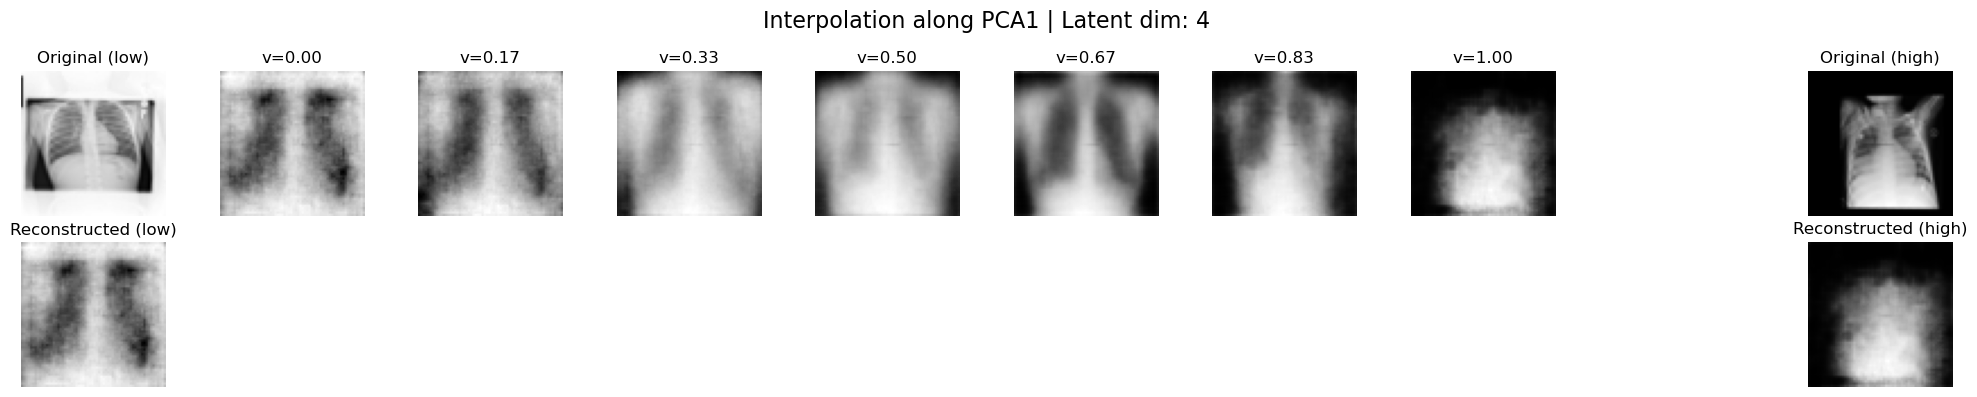

For latent dim 16


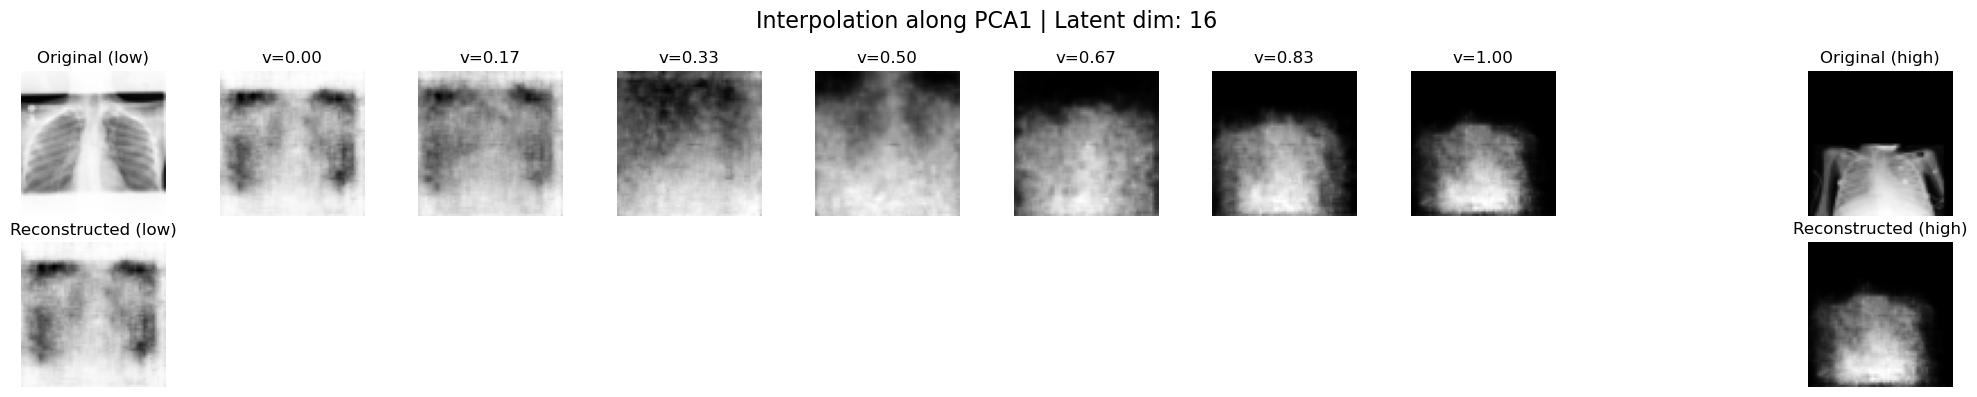

For latent dim 32


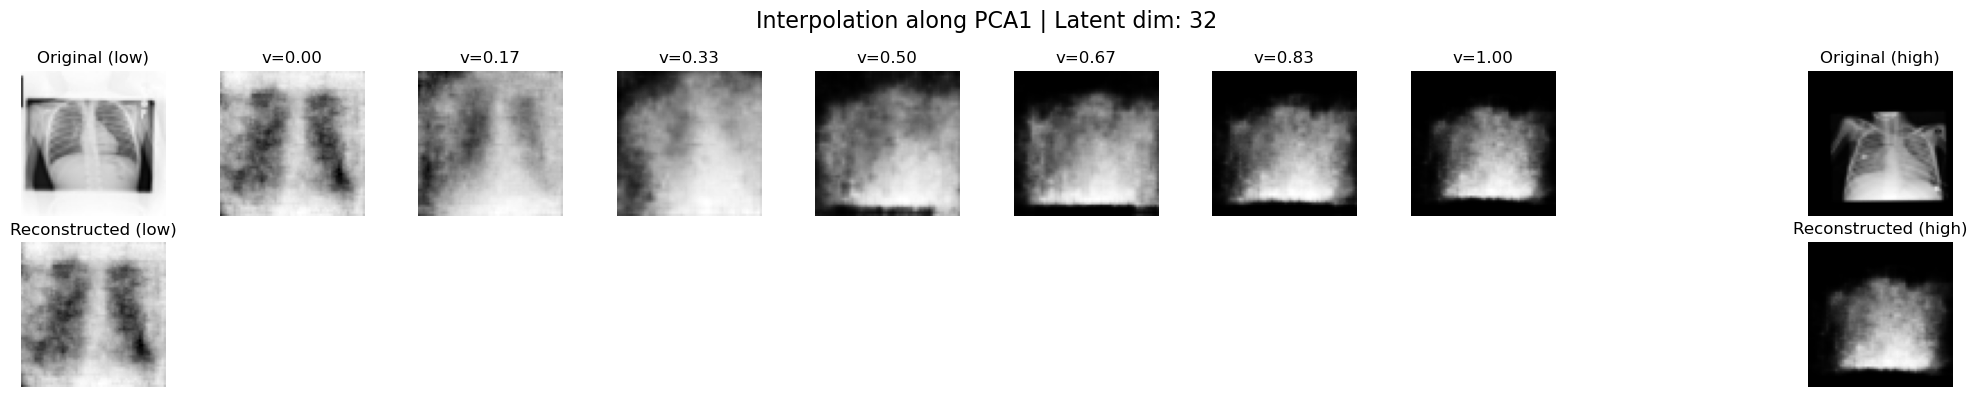

In [47]:
# pca 1
for dim in latent_dim:
    print(f"For latent dim {dim}")
    interpolate_pca(all_vaes[dim], x_test, dim, pca_axis=0)

For latent dim 4


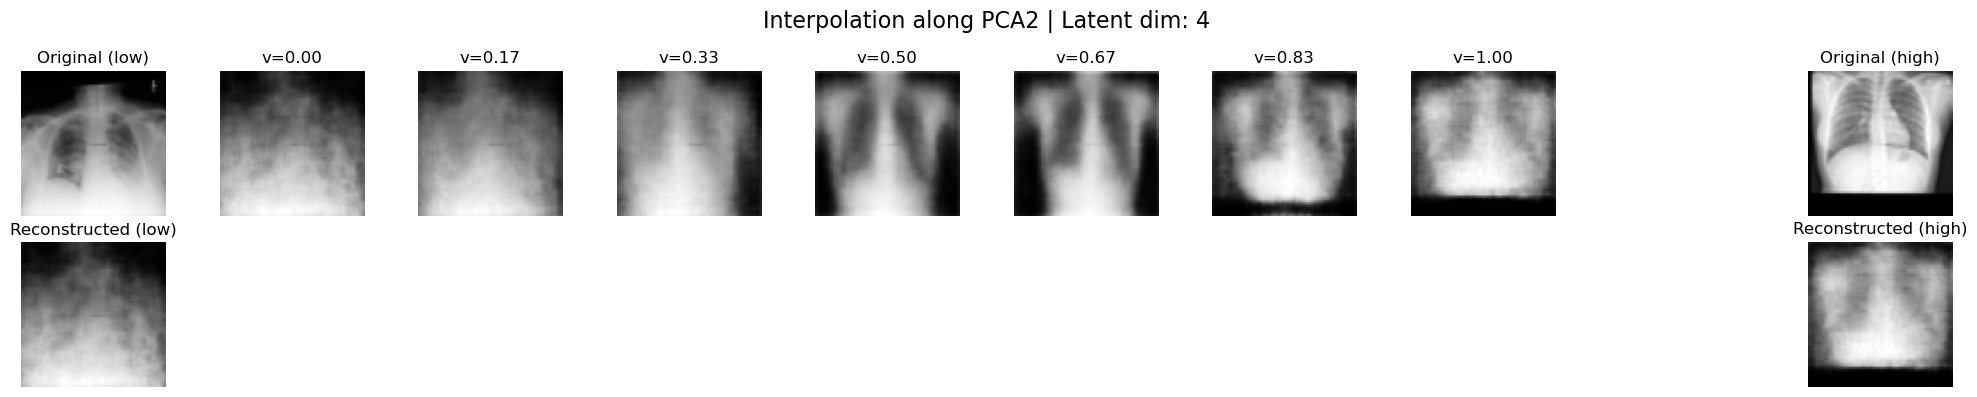

For latent dim 16


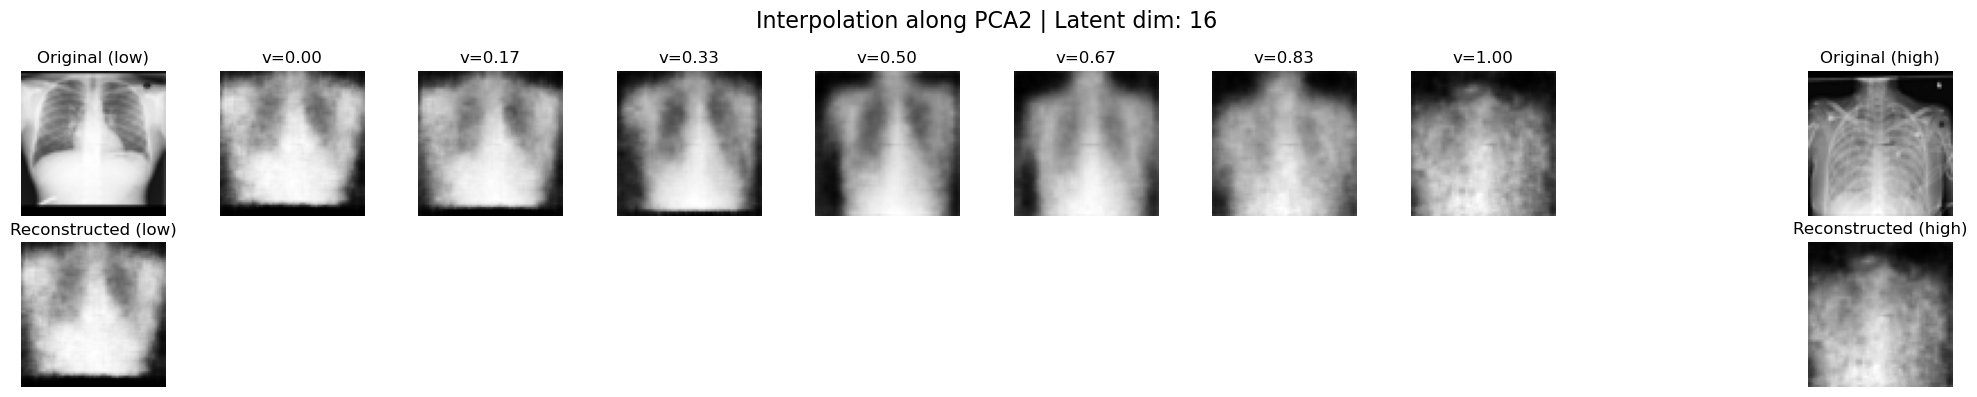

For latent dim 32


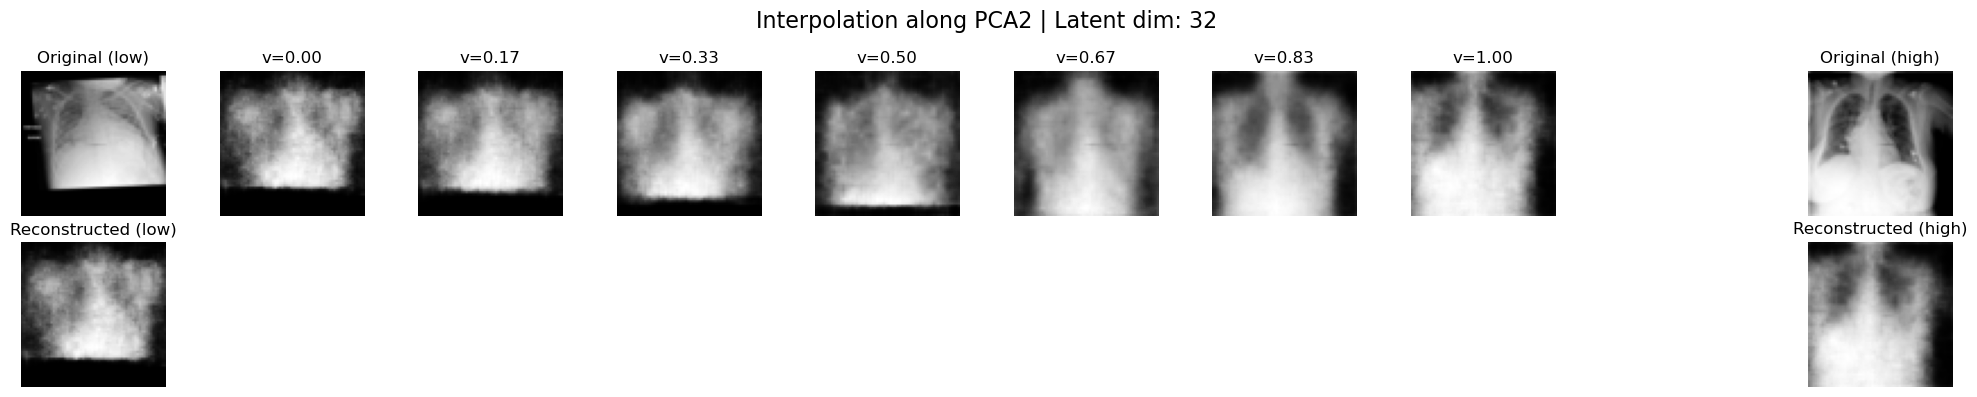

In [48]:
# pca 2
for dim in latent_dim:
    print(f"For latent dim {dim}")
    interpolate_pca(all_vaes[dim], x_test, dim, pca_axis=1)

In [33]:
def interpolate_tsne(vae, x_data, tsne_axis=0):
#     # subset
#     x_subset = x_data[np.random.choice(len(x_data), 1000, replace=False)]

    # encode
    z_mean, _, _ = vae.encoder(x_data)
    z = z_mean.numpy()

    # TSNE
    tsne = TSNE(n_components=2)
    z_tsne = tsne.fit_transform(z)

    # low high index
    low_idx = np.argmin(z_tsne[:, tsne_axis])
    high_idx = np.argmax(z_tsne[:, tsne_axis])

    low_img = x_data[low_idx]
    high_img = x_data[high_idx]

    #vector
    low_z = z[low_idx]
    high_z = z[high_idx]

    # interpolation
    vals = np.linspace(0, 1, 7)
    interpolated_z = np.array([(1 - v) * low_z + v * high_z for v in vals])
    decoded_imgs = vae.decoder(interpolated_z).numpy()

    # Plotting
    plt.figure(figsize=(20, 4))
    
    # original image (lowest TSNE)
    ax = plt.subplot(2, 10, 1)
    plt.imshow(low_img.squeeze(), cmap='gray')
    plt.title("Original (low)")
    plt.axis("off")
    
    # reconstruction of original (low)
    recon_low = vae.decoder(np.expand_dims(low_z, axis=0)).numpy()[0]
    ax = plt.subplot(2, 10, 11)
    plt.imshow(recon_low.squeeze(), cmap='gray')
    plt.title("Reconstructed (low)")
    plt.axis("off")

    # Interpolated
    for i, (img, val) in enumerate(zip(decoded_imgs, vals)):
        ax = plt.subplot(2, 10, i + 2)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"v={val:.2f}")
        plt.axis("off")

    # original image (high)
    ax = plt.subplot(2, 10, 10)
    plt.imshow(high_img.squeeze(), cmap='gray')
    plt.title("Original (high)")
    plt.axis("off")
    
    # reconstruction of original (high)
    recon_high = vae.decoder(np.expand_dims(high_z, axis=0)).numpy()[0]
    ax = plt.subplot(2, 10, 20)
    plt.imshow(recon_high.squeeze(), cmap='gray')
    plt.title("Reconstructed (high)")
    plt.axis("off")

    plt.suptitle(f"Interpolation along TSNE {tsne_axis+1}", fontsize=16)
    plt.tight_layout()
    plt.show()


For latent dim 4


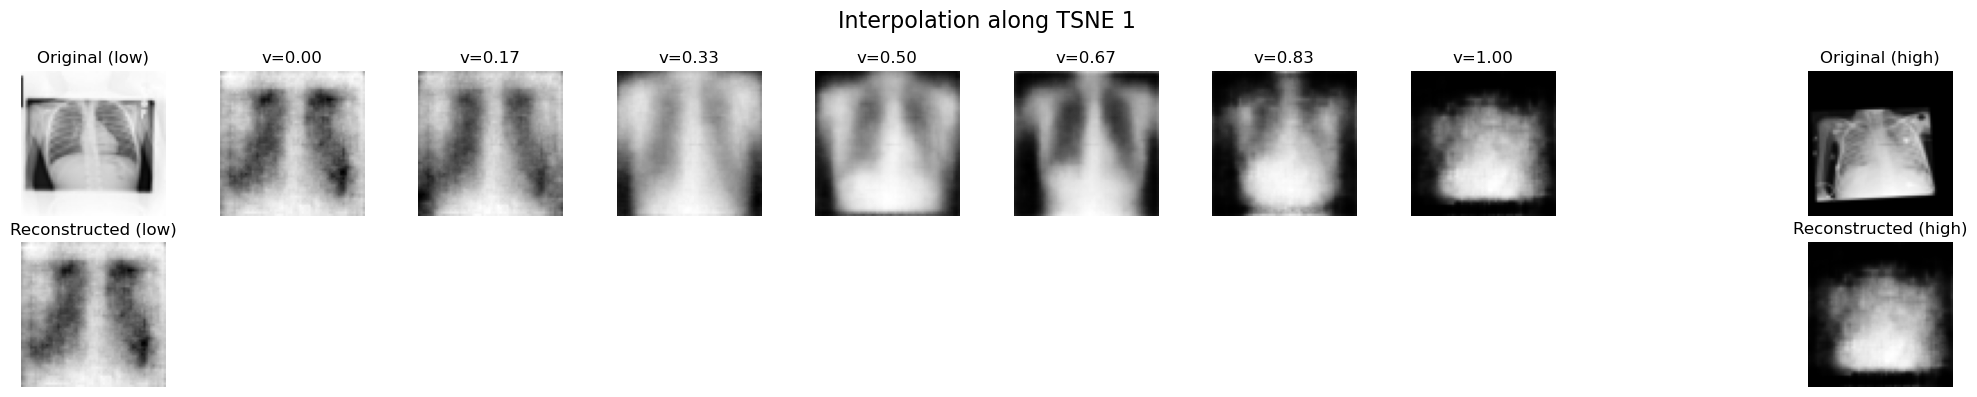

For latent dim 16


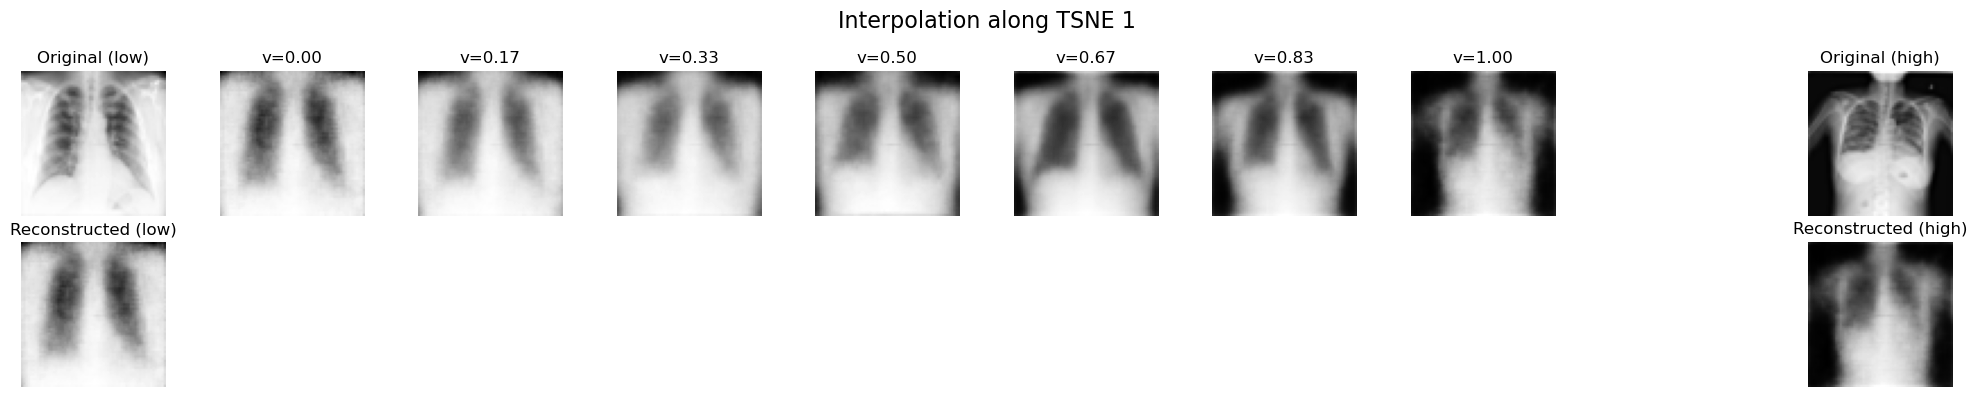

For latent dim 32


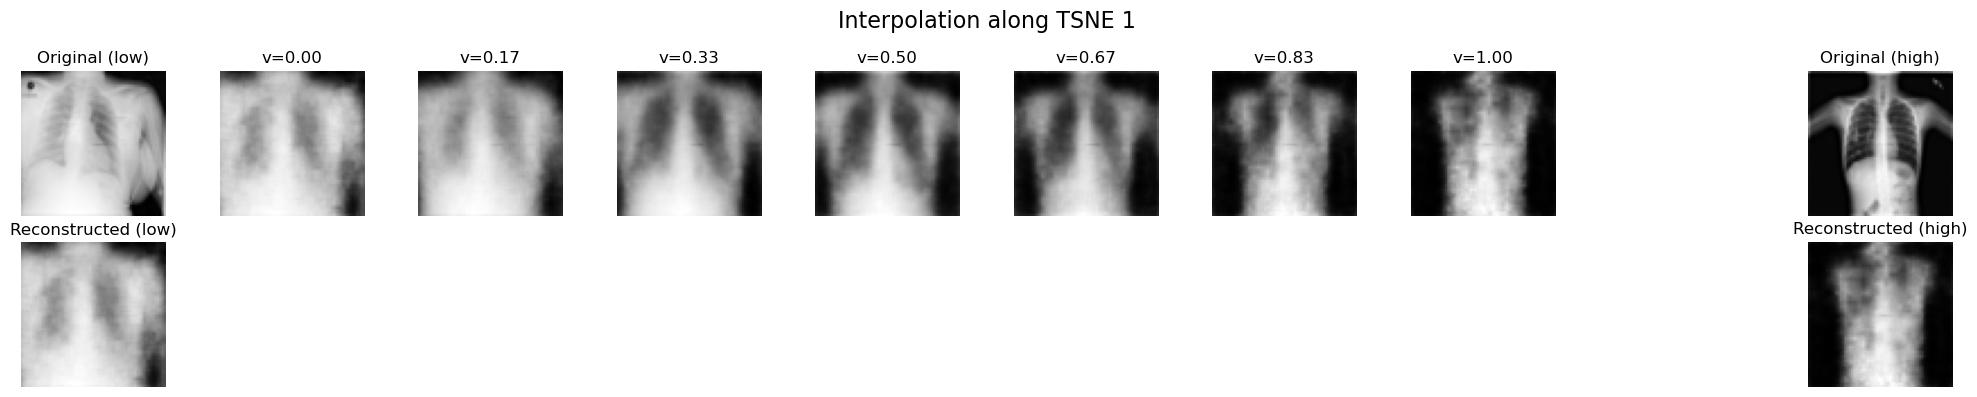

In [46]:
# tsne 1
for dim in latent_dim:
    print(f"For latent dim {dim}")
    interpolate_tsne(all_vaes[dim], x_test, tsne_axis=0)

For latent dim 4


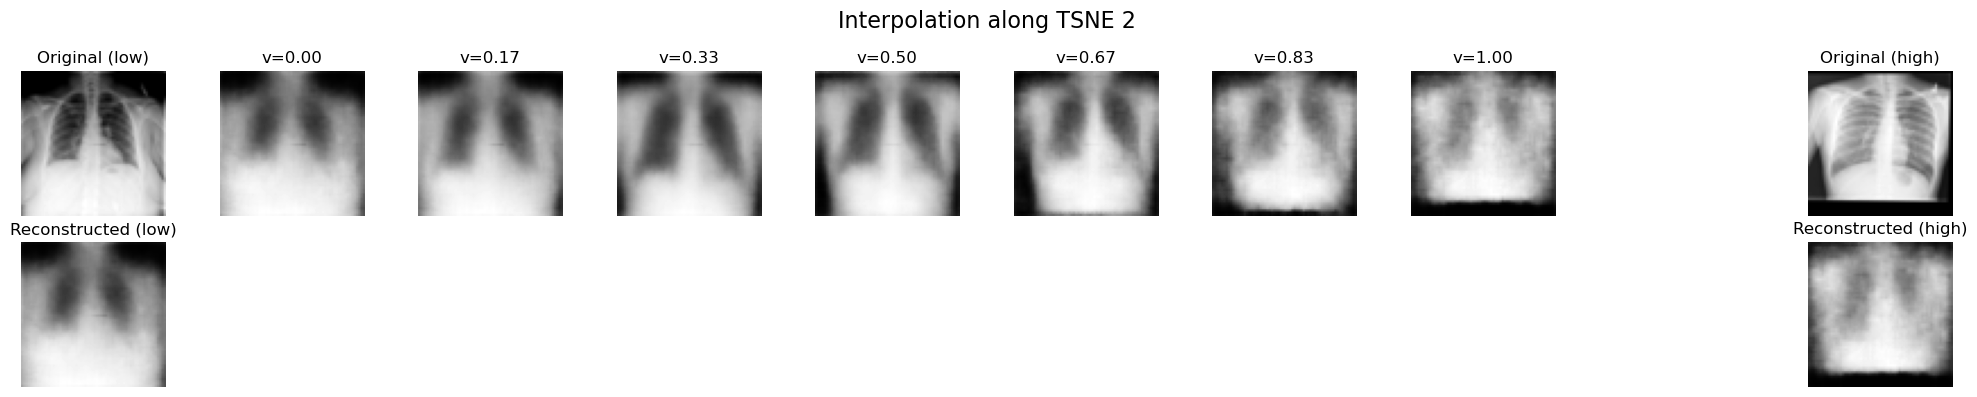

For latent dim 16


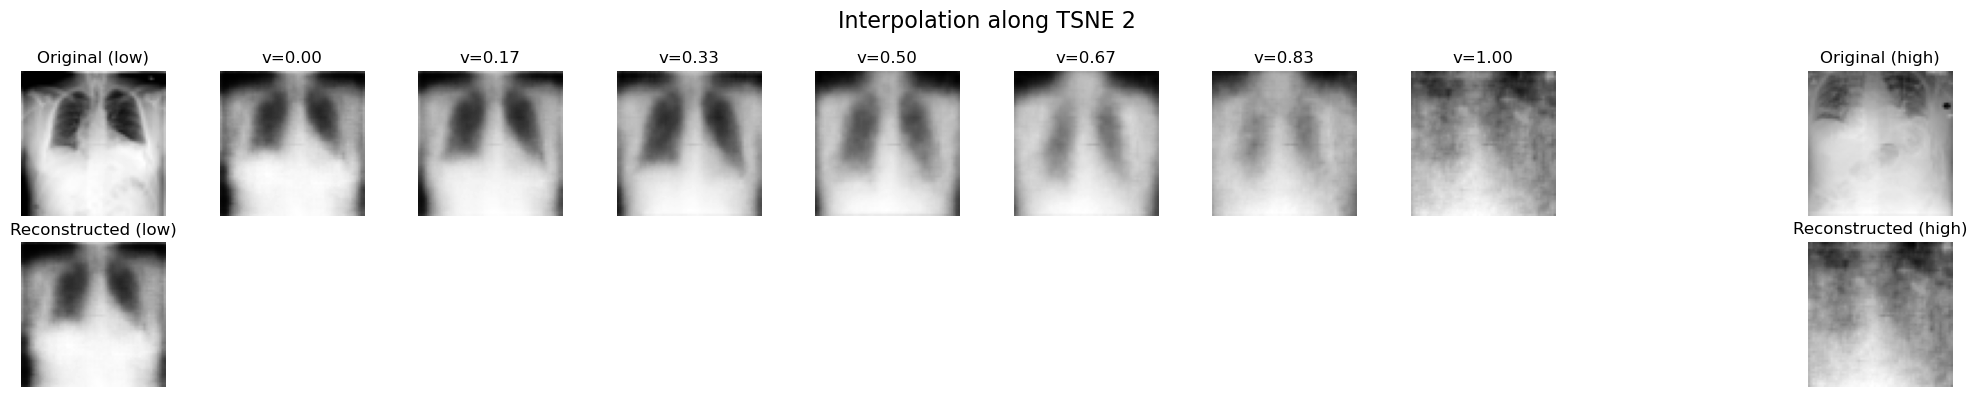

For latent dim 32


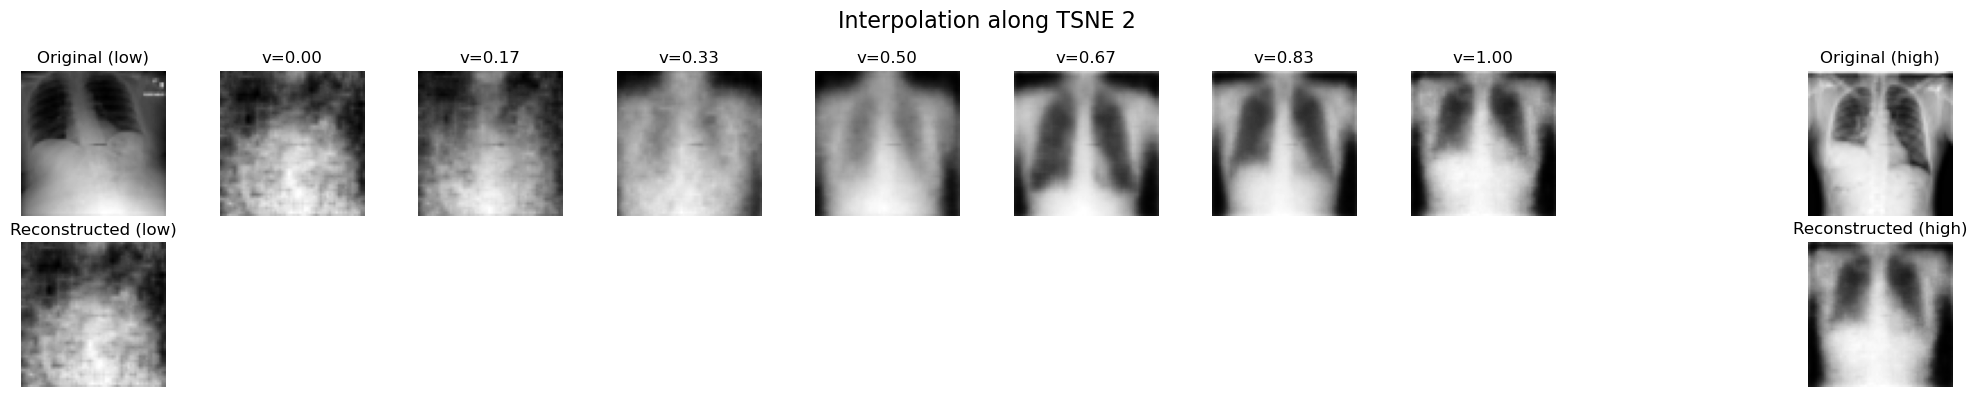

In [49]:
# tsne 2
for dim in latent_dim:
    print(f"For latent dim {dim}")
    interpolate_tsne(all_vaes[dim], x_test, tsne_axis=1)

Yeah, it seems that across latent dimensions, there is a gradual transformation in brightnesss and contrast in the lung areas (more visible ribs and lung boundaries). Across latent dimension 4 for both PCA and tSNE, the transition is coarse, with blurrier transitions. For latent dimension 16, there's more structure improvements in images rather than just pixel intensity like there is usually for dimension 4. 